In [390]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# JAX don't pre-allocate memory; allocate as-needed
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from tqdm import tqdm
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn

from tinygp import kernels, GaussianProcess
import optax

# load MNIST data
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt

In [391]:
data = mnist.load_data()

X = data[0][0] / 255.0
y = data[0][1]

print(X.shape, y.shape)

(60000, 28, 28) (60000,)


(10, 28, 28)


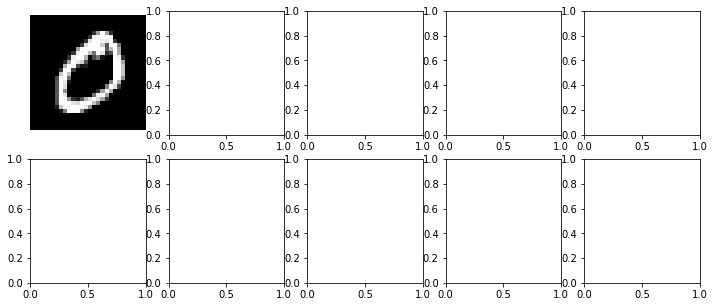

In [392]:
# select 100 examples from each class
n_each = 10
n_classes = 1
imgs = jnp.concatenate([X[y==i][:n_each] for i in range(n_classes)])
print(imgs.shape)

fig, ax = plt.subplots(2, 5, figsize=(12, 5))
ax = ax.flatten()
for i, axes in zip(range(0, n_each*n_classes, n_each), ax):
    axes.imshow(imgs[i].reshape(28, 28), cmap='gray')
    axes.axis('off')

(Array(0., dtype=float32), Array(1., dtype=float32))

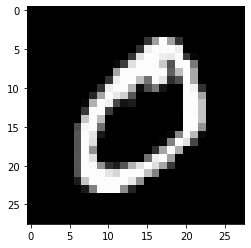

In [393]:
plt.imshow(imgs[0], cmap='gray');
imgs.min(), imgs.max()

In [423]:
class Transformer(nn.Module):
    """A small neural network used to non-linearly transform the input data"""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        # x = nn.Dense(features=256)(x)
        # x = nn.relu(x)
        # x = nn.Dense(features=256)(x)
        # x = nn.relu(x)
        x = nn.Dense(features=256)(x)
        return x

def get_gp(theta, X):
    scale = jnp.exp(theta['log_scale'])
    var = jnp.exp(theta['log_var'])
    noise_var = jnp.exp(theta['log_noise_var'])
    nn_params = theta['nn_params']
    nn_params = jax.lax.stop_gradient(nn_params) 
    
    X_nn = nn_model.apply(nn_params, X)
    print(X.shape, X_nn.shape)

    kernel = var * kernels.ExpSquared(scale=scale)
    return GaussianProcess(kernel, X_nn), X_nn

def loss_fn(theta, X, y):
    gp, X_nn = get_gp(theta, X)
    
    print("y", y.shape, y.max(), y.min())
    y_logit = jnp.log(y+1e-6) - jnp.log1p(-y+1e-6)
    return -jax.vmap(gp.log_probability)(y_logit).mean()# + jnp.mean((X_nn.ravel() - y.ravel())**2)

value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

In [424]:
n, h, w = imgs.shape
x_grid = jnp.linspace(0, 1, h)
y_grid = jnp.linspace(0, 1, w)
X, Y = jnp.meshgrid(x_grid, y_grid)
X_input = jnp.stack([X.flatten(), Y.flatten()], axis=1)
y_input = imgs.reshape(n, -1)

nn_model = Transformer()
key = jax.random.PRNGKey(0)
nn_params = nn_model.init(key, X_input)

trial_theta = {"log_scale": np.log(1.0), "log_var": np.log(1.0), "log_noise_var": np.log(1.0), "nn_params": nn_params}
value = loss_fn(trial_theta, X_input, y_input)
value

(784, 2) (784, 256)
y (10, 784) 1.0 0.0


Array(6473231., dtype=float32)

In [425]:
# def nn_loss_fn(theta, X, y):
#     y_pred = nn_model.apply(theta['nn_params'], X)
#     print(y_pred.shape, y.shape)
#     return jnp.mean((y_pred.ravel() - y.ravel())**2)

# nn_value_and_grad_fn = jax.jit(jax.value_and_grad(nn_loss_fn))

# opt = optax.adam(1e-3)
# opt_state = opt.init(trial_theta)

# def nn_one_step(theta_and_state, aux):
#     theta, opt_state = theta_and_state
#     value, grad = nn_value_and_grad_fn(theta, X_input, y_input)
#     updates, opt_state = opt.update(grad, opt_state)
#     new_theta = optax.apply_updates(theta, updates)
#     return (new_theta, opt_state), value

# (trial_theta, opt_state), loss_history = jax.lax.scan(nn_one_step, (trial_theta, opt_state), None, length=1000)
# print("final_loss", loss_history[-1])

# plt.plot(loss_history)

# value = loss_fn(trial_theta, X_input, y_input)
# value

In [426]:
# plt.imshow(nn_model.apply(trial_theta['nn_params'], X_input).reshape(28, 28).__array__(), cmap='gray');

In [427]:
theta = jax.tree_map(jnp.array, trial_theta)

optimizer = optax.adam(1e-1)
state = optimizer.init(theta)
epochs = 5000

def one_step(theta_and_state, aux):
    theta, state = theta_and_state
    loss, grads = value_and_grad_fn(theta, X_input, y_input)
    updates, state = optimizer.update(grads, state)
    theta = optax.apply_updates(theta, updates)
    return (theta, state), loss

(theta, state), loss_history = jax.lax.scan(one_step, (theta, state), None, length=epochs)

(784, 2) (784, 256)
y (10, 784) Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)> Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=2/0)>


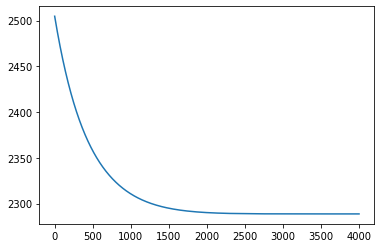

In [428]:
plt.plot(loss_history[1000:]);

(784, 2) (784, 256)
lengthscale: 0.2095336765050888, variance: 64.935546875, noise: 1.0


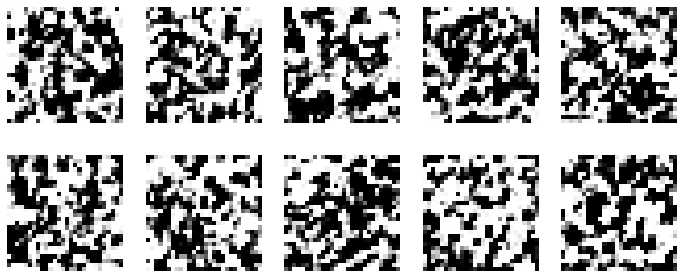

In [429]:
gp, init_gen = get_gp(theta, X_input)
print(f"lengthscale: {jnp.exp(theta['log_scale'])}, variance: {jnp.exp(theta['log_var'])}, noise: {jnp.exp(theta['log_noise_var'])}")

gen_imgs = jax.nn.sigmoid(gp.sample(jax.random.PRNGKey(0), (10,)))

# plt.imshow(init_gen.reshape(28, 28).__array__(), cmap='gray');

fig, ax = plt.subplots(2, 5, figsize=(12, 5))
ax = ax.flatten()
for i, axes in zip(range(10), ax):
    axes.imshow(gen_imgs[i].reshape(28, 28), cmap='gray')
    axes.axis('off')

In [430]:
# gen_imgs[0].min(), gen_imgs[0].max()

jnp.mean((gen_imgs[0] - y_input[0])**2)

Array(0.40566167, dtype=float32)